# 第3回のコード

資料にあるJuliaの実装。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("FFTW")
Pkg.add("Plots")
Pkg.add("Polynomials")
Pkg.add("SpecialFunctions")

```

## フーリエ級数の数値計算

与えられた関数のフーリエ係数を計算する

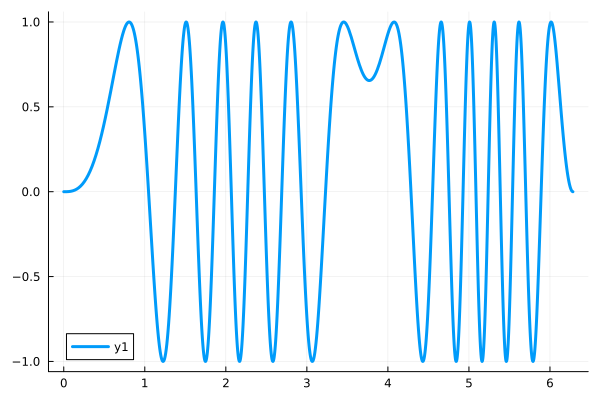

In [37]:
using FFTW, Plots, SpecialFunctions
# f(x) = exp(sin(5x))/(1+sin(cos(x)))
f(x) = sin(x^3*(x-2π)^2/10)
# f(x) = exp(erf(x^2)+x^5)*sinpi(3x) + x
plot(f,0,2π,lw=3)

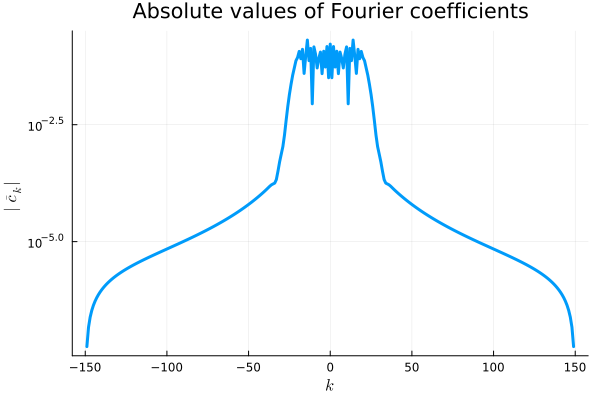

In [40]:

# f(x) = exp(x)
# f(x) = sin(x^3*(x-2π)^2/10)
# N = 1000
using ApproxFun
# setprecision(104)
N = 150

function fouriercoeffs(f,N)
    h = (2.0)*π/(2N-1)
    xⱼ = h*(0:2N-2)
    fⱼ = f.(xⱼ);
    return fftshift(fft(fⱼ))/(2N-1)
end

cₖ = fouriercoeffs(f,N)

plot(-N+1:N-1,abs.(cₖ),yscale=:log10,
    legend=false,
    xlabel = "\$k\$",
    ylabel = "\$|\\bar{c}_k\\,|\$",
    lw = 3,
    # yticks = [1e-30,1e-16,1e-8,1],
    title = "Absolute values of Fourier coefficients"
)

フーリエ係数から元の関数の概形を求める

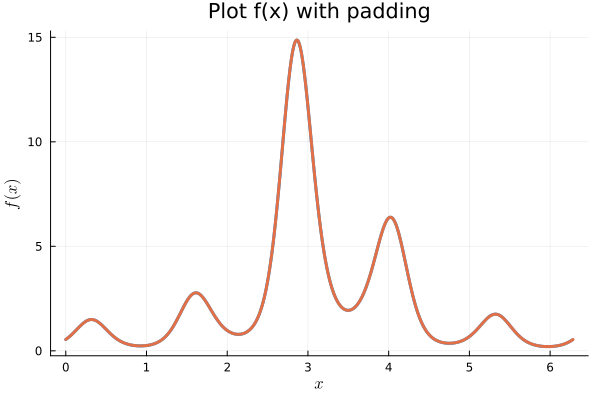

In [22]:
function plot_fourier(cₖ)
    N = (length(cₖ)+1)/2# 2N-1
    n_pad = 200
    cₖ_pad = [zeros(n_pad);cₖ;zeros(n_pad)]
    N_pad = N + n_pad
    h_pad = 2.0π/(2N_pad-1)
    xⱼ_pad = h_pad*(0:(2N_pad-2))
    
    fᴺⱼ_pad = real((2N_pad-1)*ifft(ifftshift(cₖ_pad)))
    plot(xⱼ_pad, fᴺⱼ_pad, legend=false, title = "Plot f(x) with padding",
        xlabel = "\$x\$",
        ylabel = "\$f(x)\$",lw=3)
end

plot_fourier(cₖ)
plot!(f,0,2π,lw=3)

## チェビシェフ級数


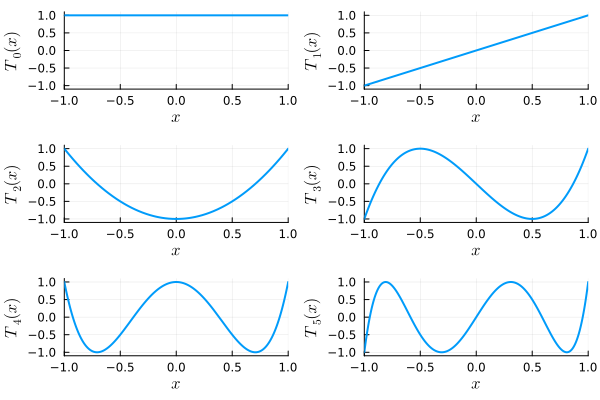

In [25]:
using Polynomials

function T(n)
    return ChebyshevT([zeros(n);1.])
end

plot(
    plot(T(0), ylabel = "\$T_0(x)\$"),
    plot(T(1), ylabel = "\$T_1(x)\$"),
    plot(T(2), ylabel = "\$T_2(x)\$"),
    plot(T(3), ylabel = "\$T_3(x)\$"),
    plot(T(4), ylabel = "\$T_4(x)\$"),
    plot(T(5), ylabel = "\$T_5(x)\$"),
    layout    = (3, 2),
    line        = 2,
    color      = 2, 
    xlabel = "\$x\$",
    xlims      = (-1, 1),
    ylims      = (-1.1, 1.1),
    legend   = false,
    lw = 3,
)

チェビシェフ点

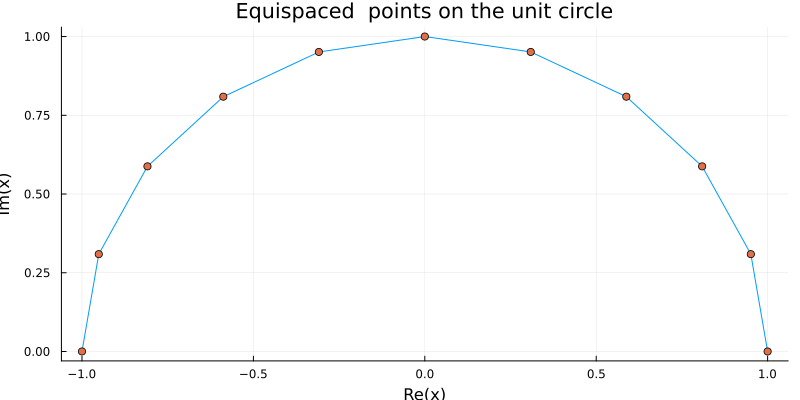

In [26]:
n = 10
tt= range(0,stop=π,length=n+1)
zz =exp.(im*tt)

plot(zz,
    title = "Equispaced  points on the unit circle",
    legend = false,
    size = (800,400),
)
scatter!(zz)

In [27]:
function chebpts(n, a=-1, b=1) # n: order of Chebyshev polynomials
    m = -n:2:n
    x = sinpi.(m/(2*n))
    return (1.0 .- x).*a/2 + (1.0 .+ x).*b/2
end

chebpts (generic function with 3 methods)

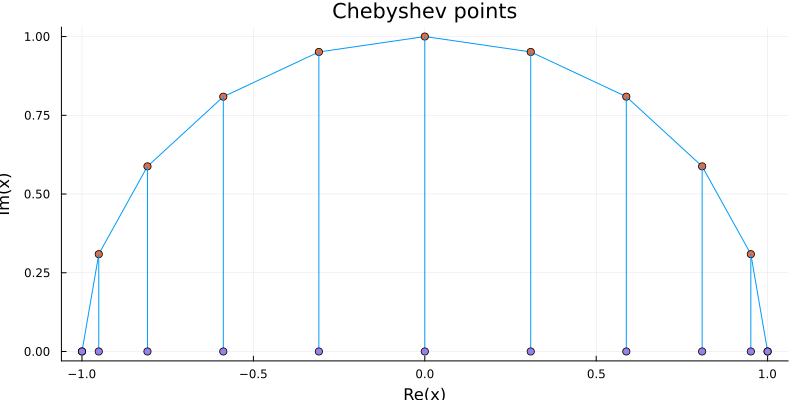

In [28]:
x = chebpts(n)
for j = 2:n
    plot!([x[j];(zz[end-j+1])],
        title = "Chebyshev points",
        legend = false,
        color=1,
    )
end
scatter!(x.+0*im)

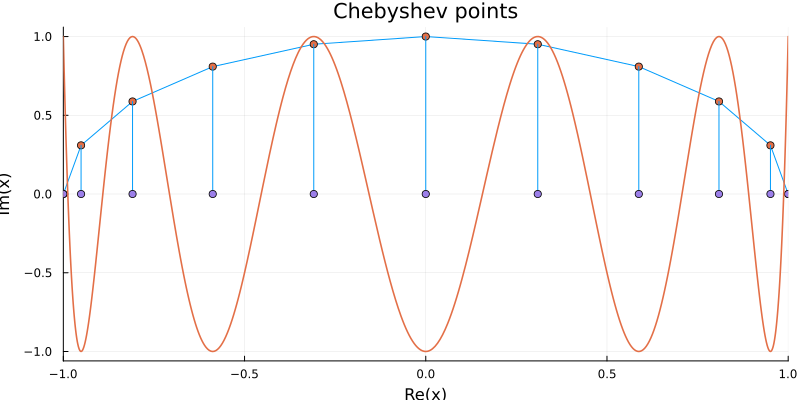

In [29]:
plot!(T(n), color=2,line= 1.6,)

チェビシェフ係数の計算

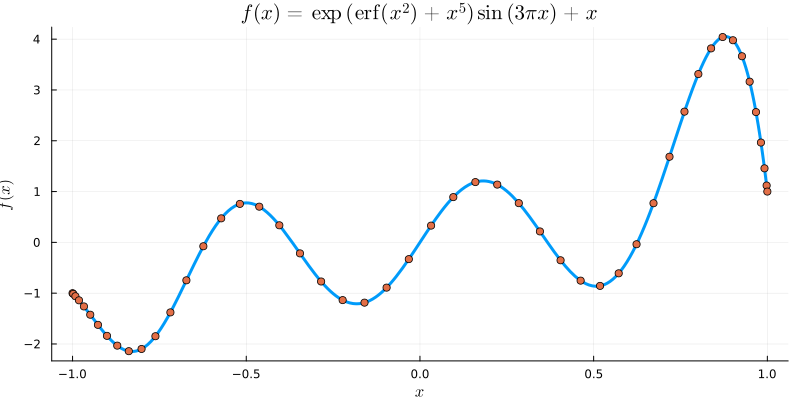

In [41]:
using SpecialFunctions
M = 50 # number of Chebyshev polynimals
# fc = Fun(x->exp(erf(x^2)+x.^5).*sin(3*pi*x) + x, Chebyshev(),M)
# n = ncoefficients(fc) - 1 # maximum order of Chebyshev polynomials (n = M-1)
fc(x) = exp(erf(x^2)+x^5)*sinpi(3x) + x
n = M-1
plot(fc,-1,1,
    xlabel     = "\$x\$",
    ylabel     = "\$f(x)\$",
    line       = 3,
    title      = "\$f(x) = \\exp\\,(\\mathrm{erf}\\,(x^2)+x^5)\\sin\\,(3\\pi x) + x\$", 
    size       = (800,400),
    legend     = false,
)

cpts = chebpts(n)
fvals = fc.(cpts)
scatter!(cpts,fvals)

In [42]:
valsUnitDisc = [reverse(fvals);fvals[2:end-1]]
FourierCoeffs = real(fft(valsUnitDisc))
ChebCoeffs = FourierCoeffs[1:n+1]/n
ChebCoeffs[1] = ChebCoeffs[1]/2
ChebCoeffs[end] = ChebCoeffs[end]/2
# reshape([ChebCoeffs; Cheb_twosided],n+1,2)
ChebCoeffs

50-element Vector{Float64}:
  0.28757258733488433
  1.9331076618493235
  0.36432115847628005
  0.35623860963875376
 -0.08209474887469631
 -0.688726918586861
 -0.3417096417884156
 -1.0073518129258836
 -0.22916475282355053
  0.5209427872876387
  ⋮
  1.0944806568983064e-12
  1.315745549886334e-13
 -2.5490221446420996e-13
  1.2384579936005048e-13
 -2.957606504480984e-14
 -3.0437970955066633e-15
  6.32093478882317e-15
 -3.249694335887823e-15
  6.99624356101571e-16

In [43]:
function chebcoeffs(f,M,I=[-1;1])
    a = I[1]; b = I[2]
    n = M-1
    cpts  = chebpts(n, a, b)
    fvals = f.(cpts)
    FourierCoeffs = real(fft([reverse(fvals);fvals[2:end-1]]))
    ChebCoeffs = FourierCoeffs[1:n+1]/n
    ChebCoeffs[1] = ChebCoeffs[1]/2
    ChebCoeffs[end] = ChebCoeffs[end]/2
    return ChebCoeffs # return Two-sided Chebyshev
end
function cheb(f,I=[-1;1];tol = 5e-15,Nmax = 10000)
    a = I[1]; b = I[2]; m = 0.5*(a+b); r = 0.5*(b-a); x = rand(5)
    x1 = m .+ x*r; x2 = m .- x*r
    if f.(x1) ≈ f.(x2)
        odd_even = 1 # even function: 1
    elseif f.(x1) ≈ -f.(x2)
        odd_even = -1 #  odd function: -1
    else
        odd_even = 0 # otherwise: 0
    end
    i = 3
    schbc = 0 # sampling chebyshev coefficients
    while true
        schbc = chebcoeffs(f,2^i+1,I)
        if all(abs.(schbc[end-2:end]) .< tol) || (2^i+1 > Nmax) 
            break
        end
        i += 1
    end    
    M = findlast(abs.(schbc) .> tol)
    cc = schbc[1:M]
    # cc = chebcoeffs(f,M,I)
    if odd_even == 1 # even function
        cc[2:2:end] .= 0
    elseif odd_even == -1 # odd function
        cc[1:2:end] .= 0
    end
    return cc # return Two-sided Chebyshev
end

cheb (generic function with 2 methods)

In [44]:
f(x) = sin(x^3*(x-2π)^2/10)
Cheb_twosided = cheb(f,[0,2π])

137-element Vector{Float64}:
  0.1602685833294358
  0.013164657574783264
 -0.008673847485528609
  0.010146943742006007
  0.015208175093975481
  0.2061254392888649
 -0.1685186935475958
 -0.1531489000712388
 -0.03973740620181498
 -0.06834685172123471
  ⋮
  2.750438765630747e-13
  2.373702363139829e-13
  6.227006757453246e-14
 -4.332211672730679e-14
 -5.476381067376357e-14
 -2.4893281880267182e-14
  2.7690523485279783e-15
  1.1998214921593586e-14
  7.615327639320935e-15

In [45]:
f(x) = 1/(1+1000*(x+.5)^2)+1/sqrt(1+1000*(x-.5)^2)
Cheb_twosided = cheb(f)

829-element Vector{Float64}:
  0.14224398378782516
  0.04823089592032273
 -0.09011322770246134
 -0.042100602989506034
 -0.08260487783403556
  0.011127573668779138
  0.13570878592379212
  0.007445949956064137
 -0.05761469203062843
 -0.00727764408623709
  ⋮
 -1.9054378842982278e-15
 -4.394699156722113e-15
  7.438991473328587e-15
 -1.2830956728961812e-15
 -5.272990160828939e-15
  4.992818766931528e-15
 -1.5164363092057959e-15
 -3.5380608558459488e-15
  5.961007918829295e-15

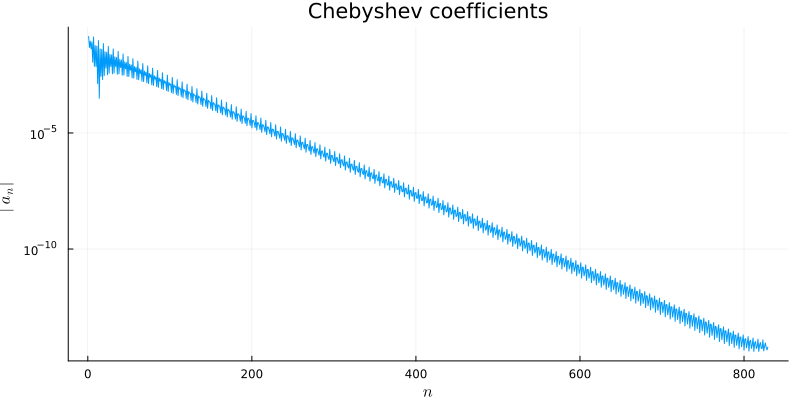

In [51]:
plot(abs.(cheb(f)),
    yscale=:log10,
    legend = false,
    xlabel="\$n\$",
    ylabel="\$|a_n\\,|\$",
    title="Chebyshev coefficients",
    size = (800,400)
)

Chebyshev係数から元の関数の概形を求める

In [52]:
function plot_cheb(ChebCoeffs_twosided;I=[-1,1],title="") # Input: Two-sided Chebyshev
    M = length(ChebCoeffs_twosided) # M: size of chebyshev
    a = I[1]; b = I[2];
    k = 0:M-1
    ξⱼ = range(-1, stop=1, length=5000)
    xc = (1.0 .- ξⱼ)*a/2 + (1.0 .+ ξⱼ)*b/2 # points in [a,b]
    fxc = cos.(Vector(k)' .* acos.(ξⱼ)) * ChebCoeffs_twosided
    plot(xc, fxc, label="plot_cheb", title=title, size=(800,400),
        xlabel="\$x\$", ylabel="\$f(x)\$")
end

plot_cheb (generic function with 1 method)

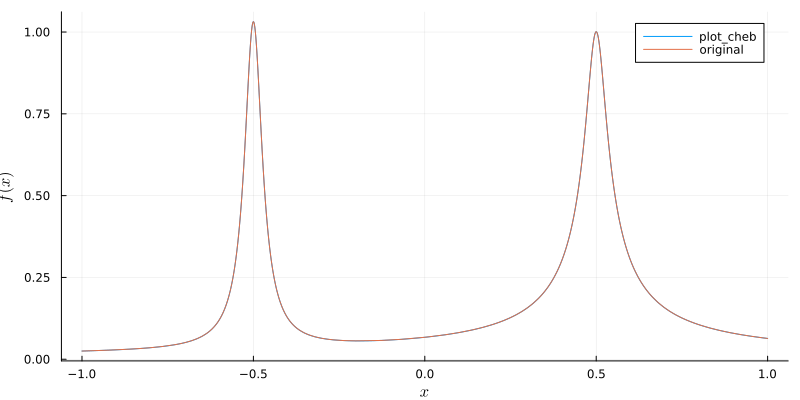

In [53]:
plot_cheb(Cheb_twosided)
plot!(f,label="original")